# ANALISIS DE PRODUCCIÓN EN POZOS NO CONVENCIONALES

In [1]:
import pandas as pd
import numpy as np
import statistics as stat
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

**CARGA DE DATOS**

Importamos los datos de la "Segunda Entrega del Proyecto Final" para ahora realizar el Future Engineering.

In [2]:
df_ML=pd.read_excel('df_ML.xlsx')
df_ML.head()

,empresa,sigla,tipoextraccion,yacimiento,Producción_Normalizada_por_Concentracion,Producción_Normalizada_por_Etapa,prod_pet_acum,agua_inyectada_m3,cantidad_fracturas,Arena_total,arena_bombeada_nacional_tn,intensidad_fluido,LRH,prod_pet,prod_gas_acum,anio_ff,intensidad_arena,anio
0,AMERICAS PETROGAS ARGENTINA S.A.,AME.Nq.LTE.x-2(h),Surgencia Natural,LOS TOLDOS ESTE,262.585340,5251.706798,18679.101,20581.9,20,4.17722,494.28,26.306623,1500.00,940.685,3086.74860,2016,1871.330898,2018
1,CHEVRON ARGENTINA S.R.L.,CHA.Nq.ET-2022h,Sin Sistema de Extracción,EL TRAPIAL,556.752034,8351.280513,27287.760,26092.5,15,3.64870,0.00,41.921512,1193.30,2799.170,11326.36114,2020,2054.674424,2021
2,CHEVRON ARGENTINA S.R.L.,CHA.Nq.ET-2022h,Sin Sistema de Extracción,EL TRAPIAL,607.890305,9118.354578,29794.170,26092.5,15,3.64870,0.00,41.921512,1193.30,2506.410,12538.65408,2020,2054.674424,2021
3,CHEVRON ARGENTINA S.R.L.,CHA.Nq.ET-2023h,Sin Sistema de Extracción,EL TRAPIAL,507.507179,15732.722553,24632.500,53804.7,31,7.45080,0.00,52.008488,1983.43,2125.820,9284.19990,2020,2524.297441,2021
4,CHEVRON ARGENTINA S.R.L.,CHA.Nq.ET-2023h,Sin Sistema de Extracción,EL TRAPIAL,546.371526,16937.517298,26518.830,53804.7,31,7.45080,0.00,52.008488,1983.43,1886.330,10083.14587,2020,2524.297441,2021


## FUTURE ENGINEERING

A continuación realicemos un conjunto de pasos con el proposito de armar un dataset que usaremos luego para nuestro modelo predictivo. Partiendo del conjunto de datos con los registros hasta el mes 12 (primer año de produccón) tomaremos solo las variables númericas que mostraron mejor correlacion con la varible de interes (prod_pet_acum) y las las variables categoricas que nos ayudan a definir con mas facilidad las correlaciones con la varible destacada. Transformaremos a variables númericas: "empresa_informante", "yacimientos" y "tipoextraccion" que fueron las varibles que usamos previamente en en los  gráficos describir cuales eran los pozos con mejores acumuladas de petróleo.

**ENCODING**

In [3]:
tipos = df_ML.dtypes
no_numericas = tipos[tipos == object].index
print(no_numericas)

Index(['empresa', 'sigla', 'tipoextraccion', 'yacimiento'], dtype='object')


In [4]:
df_ML.shape

(886, 18)

In [5]:
def createdummies(df_ML,varname):
    dummy = pd.get_dummies(df_ML[varname], prefix = varname)
    df_ML = df_ML.drop(varname, axis = 1)
    df_ML = pd.concat([df_ML, dummy], axis = 1)
    return df_ML

In [6]:
df_ML= createdummies(df_ML,"empresa")
df_ML= createdummies(df_ML,"yacimiento")
df_ML= createdummies(df_ML,"tipoextraccion")
df_ML

,sigla,Producción_Normalizada_por_Concentracion,Producción_Normalizada_por_Etapa,prod_pet_acum,agua_inyectada_m3,cantidad_fracturas,Arena_total,arena_bombeada_nacional_tn,intensidad_fluido,LRH,...,yacimiento_NARAMBUENA,yacimiento_RINCON DE ARANDA,yacimiento_SAN ROQUE VACA MUERTA,yacimiento_SIERRA BARROSA,yacimiento_SIERRAS BLANCAS,tipoextraccion_Bombeo Mecánico,tipoextraccion_Gas Lift,tipoextraccion_Plunger Lift,tipoextraccion_Sin Sistema de Extracción,tipoextraccion_Surgencia Natural
0,AME.Nq.LTE.x-2(h),262.585340,5251.706798,18679.101,20581.90000,20,4.177220,494.2800,26.306623,1500.00,...,0,0,0,0,0,0,0,0,0,1
1,CHA.Nq.ET-2022h,556.752034,8351.280513,27287.760,26092.50000,15,3.648700,0.0000,41.921512,1193.30,...,0,0,0,0,0,0,0,0,1,0
2,CHA.Nq.ET-2022h,607.890305,9118.354578,29794.170,26092.50000,15,3.648700,0.0000,41.921512,1193.30,...,0,0,0,0,0,0,0,0,1,0
3,CHA.Nq.ET-2023h,507.507179,15732.722553,24632.500,53804.70000,31,7.450800,0.0000,52.008488,1983.43,...,0,0,0,0,0,0,0,0,1,0
4,CHA.Nq.ET-2023h,546.371526,16937.517298,26518.830,53804.70000,31,7.450800,0.0000,52.008488,1983.43,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
881,YPF.Nq.SOil-406(h),627.901672,19464.951828,38123.830,42289.29442,31,7.325744,7228.4436,41.493185,1954.00,...,0,0,0,0,0,0,0,0,0,1
882,YPF.Nq.SOil-71(h),69.579137,347.895687,6276.190,3869.90000,5,0.995940,100.4850,20.512667,361.70,...,0,0,0,0,0,0,0,0,0,1
883,YPF.Nq.SOil-72(h),237.790529,3566.857934,17204.900,15950.40000,15,3.292650,688.6800,25.536828,1197.50,...,0,0,0,0,0,0,0,0,0,1
884,YPF.Nq.SOil-72(h),258.881794,3883.226907,18730.920,15950.40000,15,3.292650,688.6800,25.536828,1197.50,...,0,0,0,0,0,0,0,0,0,1


**REDUCCIÓN DE LA DIMENCIONALIDAD**

Analicemos ahora las correlaciones entre las variables de este nuevo dataset con mayor cantidad de caracteristicas, tomando "prod_pet_acum" como nuestra variable destacada o vatiable objetivo.

In [7]:
cor=df_ML.corr()
cortarget=abs(cor["prod_pet_acum"])
Var_Destacadas= cortarget[cortarget>=0.30]
print(Var_Destacadas)

Producción_Normalizada_por_Concentracion    0.959477
Producción_Normalizada_por_Etapa            0.894885
prod_pet_acum                               1.000000
agua_inyectada_m3                           0.728958
cantidad_fracturas                          0.676990
Arena_total                                 0.732483
arena_bombeada_nacional_tn                  0.679988
intensidad_fluido                           0.515555
LRH                                         0.662593
prod_pet                                    0.698852
prod_gas_acum                               0.628458
anio_ff                                     0.587930
intensidad_arena                            0.483338
anio                                        0.572912
tipoextraccion_Gas Lift                     0.316919
Name: prod_pet_acum, dtype: float64


In [8]:
Mejores_Var=df_ML[Var_Destacadas.index]
Mejores_Var

,Producción_Normalizada_por_Concentracion,Producción_Normalizada_por_Etapa,prod_pet_acum,agua_inyectada_m3,cantidad_fracturas,Arena_total,arena_bombeada_nacional_tn,intensidad_fluido,LRH,prod_pet,prod_gas_acum,anio_ff,intensidad_arena,anio,tipoextraccion_Gas Lift
0,262.585340,5251.706798,18679.101,20581.90000,20,4.177220,494.2800,26.306623,1500.00,940.685,3086.74860,2016,1871.330898,2018,0
1,556.752034,8351.280513,27287.760,26092.50000,15,3.648700,0.0000,41.921512,1193.30,2799.170,11326.36114,2020,2054.674424,2021,0
2,607.890305,9118.354578,29794.170,26092.50000,15,3.648700,0.0000,41.921512,1193.30,2506.410,12538.65408,2020,2054.674424,2021,0
3,507.507179,15732.722553,24632.500,53804.70000,31,7.450800,0.0000,52.008488,1983.43,2125.820,9284.19990,2020,2524.297441,2021,0
4,546.371526,16937.517298,26518.830,53804.70000,31,7.450800,0.0000,52.008488,1983.43,1886.330,10083.14587,2020,2524.297441,2021,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
881,627.901672,19464.951828,38123.830,42289.29442,31,7.325744,7228.4436,41.493185,1954.00,2491.010,5106.60000,2020,2519.310251,2022,0
882,69.579137,347.895687,6276.190,3869.90000,5,0.995940,100.4850,20.512667,361.70,757.380,980.87000,2015,1850.287289,2016,0
883,237.790529,3566.857934,17204.900,15950.40000,15,3.292650,688.6800,25.536828,1197.50,1304.340,2770.49000,2014,1847.670588,2015,0
884,258.881794,3883.226907,18730.920,15950.40000,15,3.292650,688.6800,25.536828,1197.50,1526.020,2872.93000,2014,1847.670588,2015,0


Este sera el dataframe que usaremos para entrenar un modelo de Machine Learning y predecir la producción de petróleo. A continución procederamos a escalar los datos.

**APLICACIÓN DE DBSCAN**

En principio calcularemos los parametros a ser unados en DBSCAN, comenzando con la distancia kn y la graficaremos para observar su valor.

In [9]:
import math

def calculate_kn_distance(Mejores_Var, k):
    kn_distance = []
    for i in range(len(Mejores_Var)):
        eucl_dist = []
        for j in range(len(Mejores_Var)):
            eucl_dist.append(math.sqrt(((Mejores_Var.iloc[i, 8] - Mejores_Var.iloc[j, 8]) ** 2) + ((Mejores_Var.iloc[i, 2] - Mejores_Var.iloc[j, 2]) ** 2)))
        eucl_dist.sort()
        kn_distance.append(eucl_dist[k])
    return kn_distance

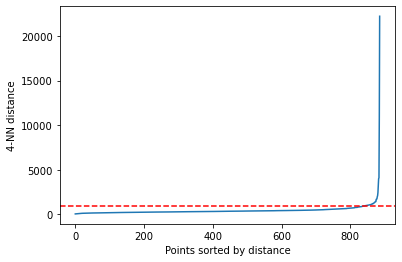

In [10]:
k = 4
eps_dist = calculate_kn_distance(Mejores_Var, k)
plt.plot(range(len(eps_dist)), sorted(eps_dist))
plt.xlabel('Points sorted by distance')
plt.ylabel(f'{k}-NN distance')
plt.axhline(y=900, color='r', linestyle='--')
plt.show()

Observamos que el valor aproximado de la distancia kn es 900. Para el otro parametros usaremos 9 ya que tenemos 8 dimenciones o variables en nuestro dataframe "Mejores_Var".

In [11]:
columnas_seleccionadas = Mejores_Var.iloc[:, [8, 2]]
dbscan = DBSCAN(eps=900, min_samples=9)
dbscan.fit(columnas_seleccionadas)

DBSCAN(eps=900, min_samples=9)

In [12]:
labels = dbscan.labels_

num_grupos = len(set(labels)) - (1 if -1 in labels else 0)

core_samples_indices = dbscan.core_sample_indices_

In [13]:
core_samples_indices.shape

(775,)

In [14]:
labels.shape

(886,)

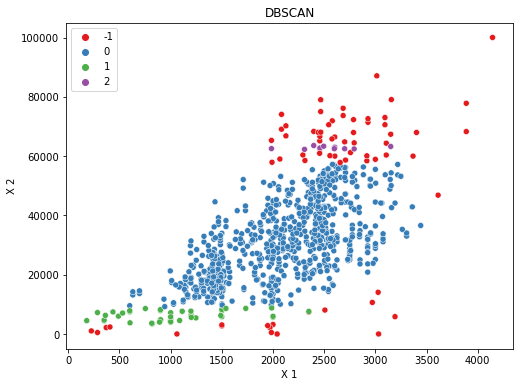

In [15]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=columnas_seleccionadas.iloc[:, 0], y=columnas_seleccionadas.iloc[:, 1], hue=labels, palette='Set1')
plt.title('DBSCAN')
plt.xlabel('X 1')
plt.ylabel('X 2')
plt.legend()
plt.show()

**CLUSTERING**

Procederemos a buscar el número optimo de clusters a usar. Aplicaremos el método deL codo.

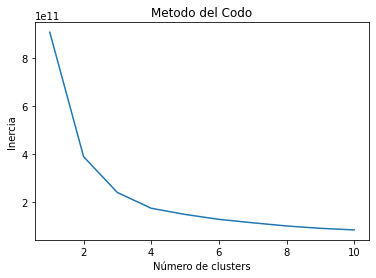

In [16]:
inercia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(Mejores_Var)
    inercia.append(kmeans.inertia_)

plt.plot(range(1, 11), inercia)
plt.title('Metodo del Codo')
plt.xlabel('Número de clusters')
plt.ylabel('Inercia')
plt.show()

De este grafico podemos observar que el número optimo de clusters seria 6, ya que justo en ese punto se observa como la curva desciende. 

In [17]:
kmeans = KMeans(n_clusters = 6, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(Mejores_Var)

In [18]:
Mejores_Var['pred'] = y_kmeans

C:\Users\gusta\AppData\Local\Temp\ipykernel_9568\693472462.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Mejores_Var['pred'] = y_kmeans


In [19]:
Mejores_Var

,Producción_Normalizada_por_Concentracion,Producción_Normalizada_por_Etapa,prod_pet_acum,agua_inyectada_m3,cantidad_fracturas,Arena_total,arena_bombeada_nacional_tn,intensidad_fluido,LRH,prod_pet,prod_gas_acum,anio_ff,intensidad_arena,anio,tipoextraccion_Gas Lift,pred
0,262.585340,5251.706798,18679.101,20581.90000,20,4.177220,494.2800,26.306623,1500.00,940.685,3086.74860,2016,1871.330898,2018,0,3
1,556.752034,8351.280513,27287.760,26092.50000,15,3.648700,0.0000,41.921512,1193.30,2799.170,11326.36114,2020,2054.674424,2021,0,1
2,607.890305,9118.354578,29794.170,26092.50000,15,3.648700,0.0000,41.921512,1193.30,2506.410,12538.65408,2020,2054.674424,2021,0,1
3,507.507179,15732.722553,24632.500,53804.70000,31,7.450800,0.0000,52.008488,1983.43,2125.820,9284.19990,2020,2524.297441,2021,0,2
4,546.371526,16937.517298,26518.830,53804.70000,31,7.450800,0.0000,52.008488,1983.43,1886.330,10083.14587,2020,2524.297441,2021,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
881,627.901672,19464.951828,38123.830,42289.29442,31,7.325744,7228.4436,41.493185,1954.00,2491.010,5106.60000,2020,2519.310251,2022,0,2
882,69.579137,347.895687,6276.190,3869.90000,5,0.995940,100.4850,20.512667,361.70,757.380,980.87000,2015,1850.287289,2016,0,3
883,237.790529,3566.857934,17204.900,15950.40000,15,3.292650,688.6800,25.536828,1197.50,1304.340,2770.49000,2014,1847.670588,2015,0,3
884,258.881794,3883.226907,18730.920,15950.40000,15,3.292650,688.6800,25.536828,1197.50,1526.020,2872.93000,2014,1847.670588,2015,0,3


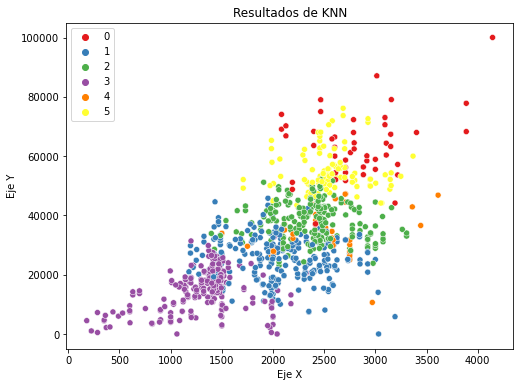

In [20]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='LRH', y='prod_pet_acum',hue='pred', data=Mejores_Var, palette='Set1')
plt.title('Resultados de KNN')
plt.xlabel('Eje X')
plt.ylabel('Eje Y')
plt.legend()
plt.show()

Se puede observar claramente como hemos agrupado nuestros datos en 6 clusters. Procederemos entonces a probar entrenar nuestro modelo usando KMeans.  Comenzamos reseteando nuestras variables **X** e **Y** y luego dividimos nuestros datos en datos de prueba (20%) y entrenamiento (80%).

**MODELO DE MACHINE LEARNING**

In [21]:
X = Mejores_Var.drop('pred', axis=1)
y = Mejores_Var['pred']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Dimensiones del conjunto de entrenamiento:", X_train.shape)
print("Dimensiones de las etiquetas de entrenamiento:", y_train.shape)

print("Dimensiones del conjunto de prueba:", X_test.shape)
print("Dimensiones de las etiquetas de prueba:", y_test.shape)

Dimensiones del conjunto de entrenamiento: (708, 15)
Dimensiones de las etiquetas de entrenamiento: (708,)
Dimensiones del conjunto de prueba: (178, 15)
Dimensiones de las etiquetas de prueba: (178,)


A continuación calcularemos la inercia de cada cluster al compararlo con el conjunto de datos de prueba.

In [22]:
means = KMeans(n_clusters=6, random_state=42)
kmeans.fit(X_train)

inercia_train = []
for label in range(kmeans.n_clusters):
    cluster_points = X_train[kmeans.labels_ == label]
    cluster_inercia = ((cluster_points - kmeans.cluster_centers_[label]) ** 2).sum()
    inercia_train.append(cluster_inercia)

# Calcular la inercia para cada cluster en el conjunto de prueba
inercia_test = []
for label in range(kmeans.n_clusters):
    cluster_points = X_test[kmeans.predict(X_test) == label]
    cluster_inercia = ((cluster_points - kmeans.cluster_centers_[label]) ** 2).sum()
    inercia_test.append(cluster_inercia)

# Imprimir las inercias de cada cluster
for label, inertia_tr, inertia_te in zip(range(kmeans.n_clusters), inercia_train, inercia_test):
    print(f"Inercia del cluster {label} en el conjunto de entrenamiento: {inertia_tr}")
    print(f"Inercia del cluster {label} en el conjunto de prueba: {inertia_te}")
    print("---")

Inercia del cluster 0 en el conjunto de entrenamiento: Producción_Normalizada_por_Concentracion    2.604461e+06
Producción_Normalizada_por_Etapa            1.683203e+09
prod_pet_acum                               1.003363e+10
agua_inyectada_m3                           1.150967e+10
cantidad_fracturas                          1.068806e+04
Arena_total                                 4.439256e+02
arena_bombeada_nacional_tn                  7.773080e+08
intensidad_fluido                           7.850796e+03
LRH                                         3.625496e+07
prod_pet                                    1.555813e+08
prod_gas_acum                               8.967026e+08
anio_ff                                     4.788724e+02
intensidad_arena                            1.869885e+07
anio                                        4.694439e+02
tipoextraccion_Gas Lift                     8.493351e-32
dtype: float64
Inercia del cluster 0 en el conjunto de prueba: Producción_Normalizada_por_

A continuación podemos observar a partir de un grafico de barras la comparación en cada uno de los clusters del modelo de entrenamiendo y los datos que se dejaron como prueba.

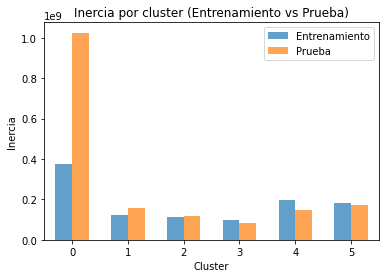

In [23]:
inercia_train = []
inercia_test = []
for i in range(kmeans.n_clusters):
    inercia_train.append(X_train[y_train == i].var().sum())
    inercia_test.append(X_test[y_test == i].var().sum())

labels = np.arange(kmeans.n_clusters)

fig, ax = plt.subplots()

width = 0.30  # Ancho de las barras
ax.bar(labels - width/2, inercia_train, width, label='Entrenamiento', alpha=0.7)
ax.bar(labels + width/2, inercia_test, width, label='Prueba', alpha=0.7)

ax.set_xlabel('Cluster')
ax.set_ylabel('Inercia')
ax.set_title('Inercia por cluster (Entrenamiento vs Prueba)')
ax.set_xlim(-0.5, 5.5)

ax.legend()

plt.show()

Observamos que el cluster 2 y el 5 son los que tienen una mejor correspondencia entre los datos de entrenamiento y los de prueba.

Aplicaremos el metodo de PCA para ajustar nuestro modelo.

In [24]:
X = Mejores_Var.drop('prod_pet_acum',1)
y = Mejores_Var['prod_pet_acum']

C:\Users\gusta\AppData\Local\Temp\ipykernel_9568\3112952883.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = Mejores_Var.drop('prod_pet_acum',1)


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [26]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [27]:
pca = PCA()
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [28]:
explained_variance = pca.explained_variance_ratio_
explained_variance

array([5.95295056e-01, 9.42965010e-02, 8.68790086e-02, 6.50318601e-02,
       4.42506856e-02, 3.63344078e-02, 2.84120280e-02, 2.04525437e-02,
       1.02853598e-02, 7.98403684e-03, 6.45409545e-03, 2.30425791e-03,
       9.42613067e-04, 7.23126001e-04, 3.54420181e-04])

Busquemos el número de componenetes a usar.

In [29]:
def buscar_componentes(Mejores_Var, var_min=0.95, plot=True):

#Busqueda de cantidad de componentes principales necesarios

    if plot:

        model = make_pipeline(StandardScaler(),PCA())
        model.fit(Mejores_Var)
        N = model.named_steps['pca'].n_components_
        VAR = model.named_steps['pca'].explained_variance_ratio_
        x_graf = [i+1 for i in range(N)]
        variance = np.cumsum(VAR)
        i_lim = sum(variance < var_min)
        v_lim = variance[i_lim]

        fig, ax = plt.subplots() 
        ax.plot(x_graf, variance,'-o')
        ax.annotate(str(i_lim+1)+', '+'{0:.3f}'.format(v_lim), xy=(i_lim+1, v_lim), xytext=(i_lim+1,0.8), ha='center',textcoords='data', arrowprops=dict(arrowstyle="->"))
        ax.set_xlabel('Número de Componentes')
        ax.set_ylabel('Varianza Acumulada')
        ax.set_ylim([0, 1])
        plt.show()

    model = make_pipeline(StandardScaler(),PCA(var_min))
    model.fit(Mejores_Var)

    if plot: print('Cantidad de componentes para 0.95: ' + str(model.named_steps['pca'].n_components_))
    return model

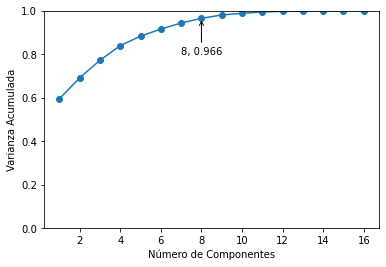

Cantidad de componentes para 0.95: 8


In [30]:
model_ML=buscar_componentes(Mejores_Var, 0.95)

In [31]:
pca = PCA(n_components=8)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

Finalmente obtenemos los valores para nuestro modelo base.

In [32]:
def mae(y_true, y_pred):
    return np.average(abs(y_true - y_pred))
baseline_guess = np.median(y_train)
basic_baseline_mae = mae(y_test, baseline_guess)
print("Valor de base para la Acumulada de Petróleo al primer año: {:.02f}".format(baseline_guess))
print("Baseline Performance on the test set: MAE = {:.04f}".format(basic_baseline_mae))

Valor de base para la Acumulada de Petróleo al primer año: 28874.58
Baseline Performance on the test set: MAE = 13587.4789


## **EVALUACION DE MODELOS DE MACHINE LEARNING**

In [33]:
!pip install xgboost 
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
import xgboost as xgb

Entrenemos y hagamos predicciones con nuestro modelo base para luego compararlo con distintos modelos de regresión y asi determinar cual presenta un valor de MAE menor.

In [34]:
def fit_and_evaluate(model):
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions and evalute
    model_pred = model.predict(X_test)
    model_mae = mae(y_test, model_pred)
    
    # Return the performance metric
    return model_mae

Usaremos los modelos de Random Forest, K-nearest neigbours, Ridge y XGBoost que segun el proposito de nuestro analisis (poder predecir la acumulada de petróleo en pozos no convencionales, para evaluar la rentabilidad de los pozos basados en la elección de los mejores parametros de fractura) son los que mejor pueden aplicarse a nuestro dataset.

In [35]:
random_forest = RandomForestRegressor(random_state=60)
random_forest_mae = fit_and_evaluate(random_forest)

print("Random Forest Regression Performance on the test set: MAE = {:.04f}".format(random_forest_mae))

Random Forest Regression Performance on the test set: MAE = 4011.2963


In [36]:
knn = KNeighborsRegressor(n_neighbors=8)
knn_mae = fit_and_evaluate(knn)

print("K-Nearest Neighbors Regression Performance on the test set: MAE = {:.04f}".format(knn_mae))

K-Nearest Neighbors Regression Performance on the test set: MAE = 4548.3513


In [37]:
ridge = Ridge(alpha=10)
ridge_mae = fit_and_evaluate(ridge)

print("Ridge Regression Performance on the test set: MAE = {:.04f}".format(ridge_mae))

Ridge Regression Performance on the test set: MAE = 5657.5282


In [38]:
xgBoost = xgb.XGBRegressor(random_state=60)
xgBoost_mae = fit_and_evaluate(xgBoost)

print("XGBoost Reggressor Performance on the test set: MAE = {:.04f}".format(xgBoost_mae))

XGBoost Reggressor Performance on the test set: MAE = 4233.4355


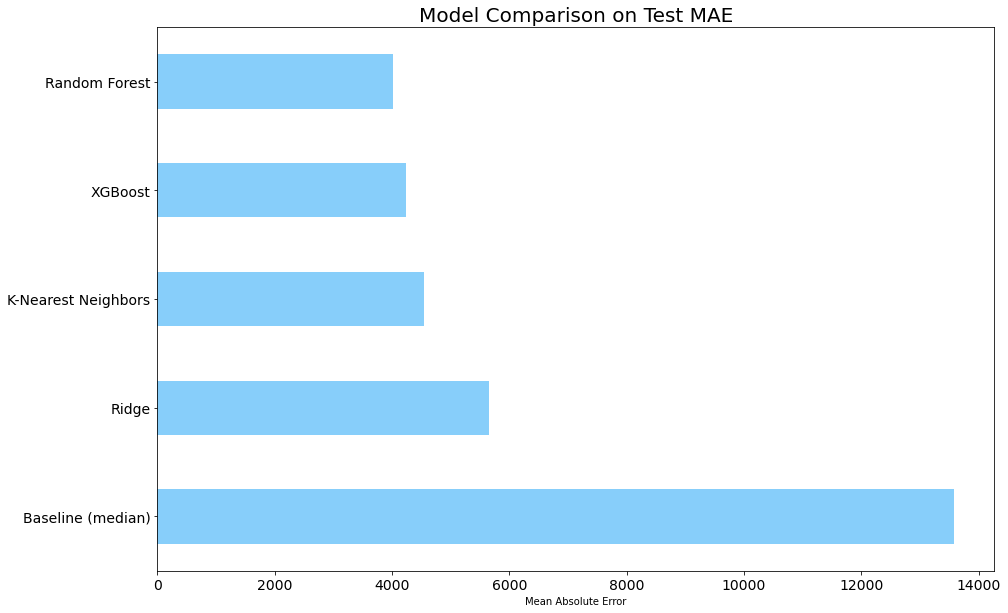

In [39]:
model_comparison = pd.DataFrame({"model": ["Random Forest",
                                            "K-Nearest Neighbors","Baseline (median)", "Ridge", "XGBoost"],
                                 "mae": [random_forest_mae, knn_mae, basic_baseline_mae, ridge_mae, xgBoost_mae]})
model_comparison.sort_values("mae", ascending=False).plot(x="model", y="mae", kind="barh",
                                                           color="lightskyblue", legend=False,figsize=(15,10))
plt.ylabel(""); plt.yticks(size=14); plt.xlabel("Mean Absolute Error"); plt.xticks(size=14)
plt.title("Model Comparison on Test MAE", size=20);

Observamos que existe una gran similitud entre los modelos Random Forest y XG-Boost. Procedemos entonces a optimizar los hiperparámetros de ambos modelos para luego evaluar cuál de estos posee un mejor performance.

### OPTIMIZACIÓN DE HIPERPARAMETROS

Comenzaremos definiendo una grilla de hiperparámetros para optimizar los distintos modelos de ML elegidos mediante RandomizedSearch, y luego mediante GridSearch, evaluando dichos modelos en búsqueda del mejor performance. El modelo que presente el mayor Coeficiente de Determinación sera el modelo final usado para la predicción de la acumulada de petróleo.

In [40]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, learning_curve
from sklearn.metrics import r2_score

#Cantidad óptima de clústers seleccionada
cv = 6

# Loss function to be optimized
loss = ["ls", "lad", "huber"]

# Maximum depth of each tree
max_depth = [2, 3, 5, 10, 15]

# Minimum number of samples per leaf
min_samples_leaf = [1, 2, 4, 6, 8]

# Minimum number of samples to split a node
min_samples_split = [1, 2, 4, 6, 10]

# Maximum number of features to consider for making splits
max_features = ["auto", "sqrt", "log2", None]

hyperparameter_grid = {"loss": loss,
                       "max_depth": max_depth,
                       "min_samples_leaf": min_samples_leaf,
                       "min_samples_split": min_samples_split,
                       "max_features": max_features}

trees_grid = {"n_estimators": [50, 100, 150, 200, 250, 300]}

In [41]:
#Random Forest

n_estimators = [50,100,250,300]

hyperparameters = dict(n_estimators=n_estimators)

random_forest_model = RandomForestRegressor(random_state=60)

rf_grid_search = GridSearchCV(estimator=random_forest_model, param_grid=hyperparameters, cv=cv, 
                           scoring="neg_mean_absolute_error", verbose=1,
                           n_jobs=-1, return_train_score=True)

rf_grid_search.fit(X_train, y_train)

rf_final_model = rf_grid_search.best_estimator_

print("\n Random Forest Model performance on the test set: R2 = {:.04f}".format(r2_score(y_test,rf_final_model.predict(X_test))))

Fitting 6 folds for each of 4 candidates, totalling 24 fits

 Random Forest Model performance on the test set: R2 = 0.8814


In [42]:
#XG-Boost

xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=60)

xgb_grid_search = GridSearchCV(estimator=xgb_model, param_grid=hyperparameters, cv=cv,
                               scoring="neg_mean_absolute_error", verbose=1,
                               n_jobs=-1, return_train_score=True)

xgb_grid_search.fit(X_train, y_train)

xgb_final_model = xgb_grid_search.best_estimator_

print("\n XGBoost Model performance on the test set: R2 = {:.04f}".format(r2_score(y_test,xgb_final_model.predict(X_test))))

Fitting 6 folds for each of 4 candidates, totalling 24 fits

 XGBoost Model performance on the test set: R2 = 0.8618


A continuación graficaremos las curvas de entrenamiento y de prueba para definir cual de los modelos funciona mejor.

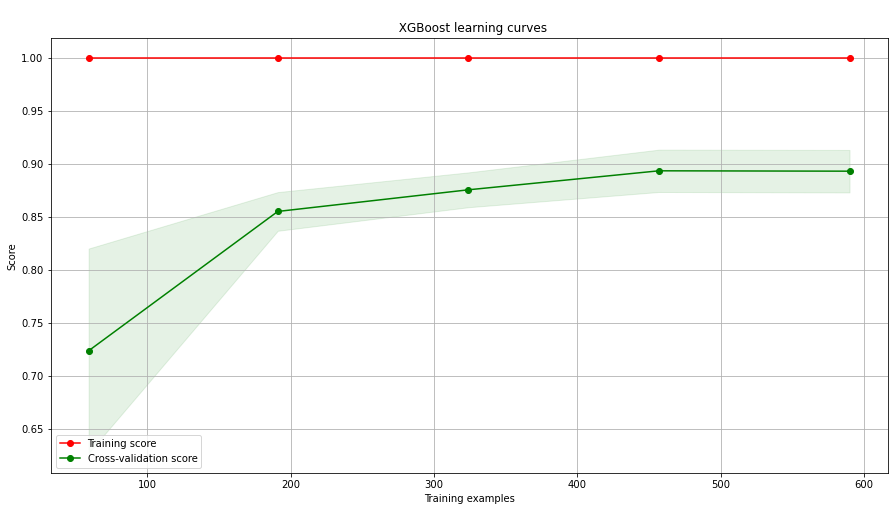

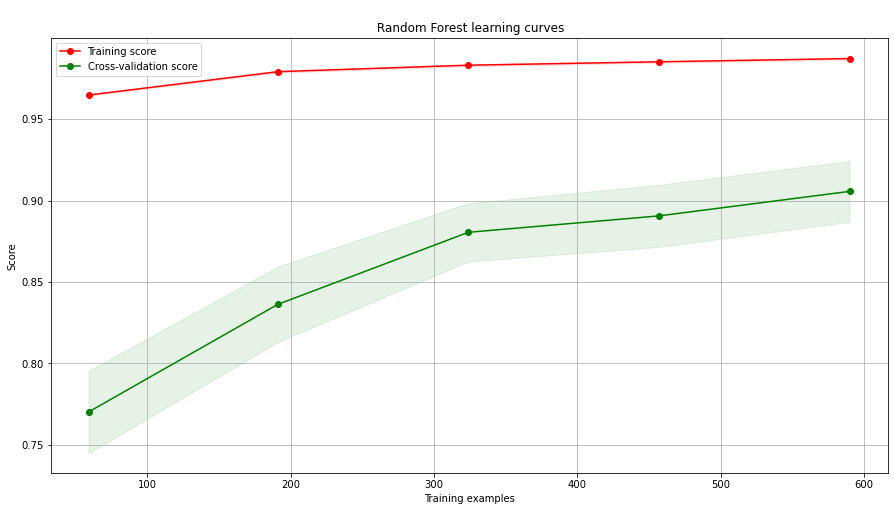

In [43]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure(figsize=(15,8))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(xgb_grid_search.best_estimator_,"\n  XGBoost learning curves",X_train,y_train,cv=cv)
g = plot_learning_curve(rf_grid_search.best_estimator_,"\n Random Forest learning curves",X_train,y_train,cv=cv)

Con respecto a estos gráficos podemos observar que en el modelo Random Forest las curvas se muestran mas paralelas que en el modelo XG_Boost; sin embargo en ambos modelos podria interpretarse que ambos tienden a sobreajustarse ya que no logra generalizar los datos y la curva de Training Score no nos muestra "sombra".